# Thermodynamic and Dynamic Contributions to SIT Variability

## Version Control

9/7 MW: 1-Lag autocorrelation maps added to notebook. Might be worth exploring multiple lags, the one-month lag autocorrelation and cross-correlations are pretty saturated at values near or > +/-0.8. 

9/9 ZE: Add theory for SIT reconstruction and prediction. Need to think a bit more about prediction theory. Added dask. Added analysis looking at autocorrelation and cross correlation at different lag times. 

9/19 MW: Add in filtering for thermodynamic and dynamic components. Seems to make sense at first glance-- more variability in dynamic component at most timescales in general, more central arctic variability in thermodynamic component at long timescales. Didn't use dask but had requested 20 GB of memory for the Casper notebook batch job.  

## Theory


 ## Reconstruction of sea ice thickness from thermodynamic and dynamic contributions

 ### (1) $\frac{dh}{dt} = \frac{dh_{thermo}}{dt} + \frac{dh_{dyn}}{dt}$ 
 
 ### (2) $ \sum_{m=0}^{m=n} \frac{dh^m}{dt} \Delta t =   \sum_{m=0}^{m=n}  \frac{dh^m_{thermo}}{dt} \Delta t +  \sum_{m=0}^{m=n}  \frac{dh^m_{dyn}}{dt} \Delta t$ 
 
 ### (3) $ h^n = h^n_{thermo} + h^n_{dyn}$ 
 
 ## Predicting sea ice thickness timeseries from k-month lag autocorrelations and cross-correlations
 Note that auto and cross correlations may peak at different lag times such that $k_1 \neq k_2 \neq k_3 \neq k_4$. Before building a timeseries of predicted sea ice thickness values, lets find the lag times where the correlations peak.
 TODO: need to talk with CC about dimensions. Autocorrelation has dims of 1/time, as in Hasselman model, so how does this work out?
 ### (4) $ h^{n+1} = r_t h^n + r_d h^n + r_{td} h^n + r_{dt}h^n$ 

 ### (4a) $r_t = -ln(C(h^{n}_{ther}, h^{n-k_1}_{ther}))$
 ### (4b) $r_d = -ln(C(h^{n}_{dyn}, h^{n-k_2}_{dyn}))$
 ### (4c) $r_{td} = -ln(C(h^{n}_{ther}, h^{n-k_3}_{dyn}))$
 ### (4d) $r_{dt} = -ln(C(h^{n}_{dyn}, h^{n-k_4}_{ther}))$
 


## Analysis

In [1]:
import glob
from functools import partial

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import geopandas as gpd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal as signal
import seaborn as sns
import xarray as xr
from shapely.geometry import Polygon

### Dask

In [2]:
from dask_jobqueue import PBSCluster

cluster = PBSCluster(
    # Job scheduler specific keywords
    project="UWAS0118",
    walltime="06:00:00",
    memory='64GB', # Absurd amount of memory :/ 
    # Dask-worker specific keyworkds
    processes=1,  # Number of Python processes to cut up each job
)
cluster.scale(10)
from dask.distributed import Client

client = Client(cluster)
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.148.10.19:36185,Workers: 0
Dashboard: /proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


### Functions

In [2]:
def mass_to_volume(Array):

    # list the number of days per month
    dpm = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]

    # use xr.groupby functionality to quickly multiply values by the
    # number of days in respective months
    month_list = [Array.groupby("time.month")[i] * dpm[i - 1] for i in range(1, 13)]

    # concatenate the data in a new DataArray
    data_by_month = xr.concat(month_list, dim="time")

    # reorganize the data quickly by year, inserting into a list to access the values
    year_list = [data_by_month.groupby("time.year")[i] for i in range(1, 1201)]

    # concatenate again across time, this time wrt year
    data_by_year = xr.concat(year_list, dim="time")

    # multiply by the number of seconds in a day and divide by the average density of sea ice
    volume_tendency = data_by_year * 60 * 60 * 24 / 940

    return volume_tendency

In [3]:
def markov_2(t1, t2, lag):

    cov, corr = lag_linregress_3D(t1, t2, lagx=0, lagy=lag)

    r = -1 * np.log(corr)

    return corr, cov, r


def lag_linregress_3D(x, y, lagx=0, lagy=0):
    """Input: Two xr.Datarrays of any dimensions with the first dim being time.
    Thus the input data could be a 1D time series, or for example, have three
    dimensions (time,lat,lon).
    Datasets can be provided in any order, but note that the regression slope
    and intercept will be calculated for y with respect to x.
    Output: Covariance, correlation, regression slope and intercept, p-value,
    and standard error on regression between the two datasets along their
    aligned time dimension.
    Lag values can be assigned to either of the data, with lagx shifting x, and
    lagy shifting y, with the specified lag amount.
    """
    # 1. Ensure that the data are properly alinged to each other.
    x, y = xr.align(x, y)
    # 2. Add lag information if any, and shift the data accordingly
    if lagx != 0:

        # If x lags y by 1, x must be shifted 1 step backwards.
        # But as the 'zero-th' value is nonexistant, xr assigns it as invalid
        # (nan). Hence it needs to be dropped
        # x   = x.shift(time = -lagx) #.dropna(dim='time')
        x = x.shift(time=-lagx)  # .dropna(dim='time')

        # Next important step is to re-align the two datasets so that y adjusts
        # to the changed coordinates of x
        x, y = xr.align(x, y)

    if lagy != 0:
        # y   = y.shift(time = -lagy)#.dropna(dim='time')
        y = y.shift(time=-lagy)  # .dropna(dim='time')
        x, y = xr.align(x, y)

    # 3. Compute data length, mean and standard deviation along time axis:
    n = y.notnull().sum(dim="time")
    xmean = x.mean(dim="time")
    ymean = y.mean(dim="time")
    xstd = x.std(dim="time")
    ystd = y.std(dim="time")

    # 4. Compute covariance along time axis
    cov = np.sum((x - xmean) * (y - ymean), axis=0) / (n)

    # 5. Compute correlation along time axis
    cor = cov / (xstd * ystd)

    return cov, cor

In [4]:
def get_monthly_anomalies(new_data):

    # new_data = detrend_data(data)

    climat = new_data.groupby("time.month").mean(dim="time")
    data = new_data.groupby("time.month") - climat

    polyfit = data.polyfit(dim="time", deg=1)  # , skipna=True)
    trend = xr.polyval(data.time, polyfit.polyfit_coefficients)
    anoms = data - trend

    return anoms


def fashion_space(ax):
    """set standard design paramaters for hemispheric stereo plots"""

    ax.set_extent([-180, 180, 55, 90], ccrs.PlateCarree())
    ax.coastlines()
    ax.add_feature(cfeature.LAND, facecolor="gainsboro", zorder=6)
    ax.gridlines()

    theta = np.linspace(0, 2 * np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = matplotlib.path.Path(verts * radius + center)

    ax.set_boundary(circle, transform=ax.transAxes)


def convert_coords(lat, lon, og_data, ccrs_grid):
    """convert data to appropriate coordinates for ccrs plot"""

    grid = ccrs_grid
    coords = grid.transform_points(ccrs.PlateCarree(), np.array(lon), np.array(lat))

    xs = np.ma.masked_invalid(coords[..., 0])
    ys = np.ma.masked_invalid(coords[..., 1])
    data = np.ma.masked_invalid(og_data)
    data.mask = np.logical_or(data.mask, xs.mask, ys.mask)

    xs = xs.filled(0)
    ys = ys.filled(0)

    return xs, ys, data

### Data Access

Pull data from CESM2 archive

In [5]:
pathth = sorted(
    glob.glob(
        "/glade/collections/cmip/CMIP6/CMIP/NCAR/CESM2/piControl/r1i1p1f1/SImon/sidmassth/gn/v20190320/*"
    )
)
pathdyn = sorted(
    glob.glob(
        "/glade/collections/cmip/CMIP6/CMIP/NCAR/CESM2/piControl/r1i1p1f1/SImon/sidmassdyn/gn/v20190320/*"
    )
)

Open files

In [6]:
therm = xr.open_mfdataset(pathth, parallel=True)
dynam = xr.open_mfdataset(pathdyn, parallel=True)

/glade/u/home/mollyw/.local/lib/python3.7/site-packages/xarray/conventions.py:520: SerializationWarning: variable 'sidmassth' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  decode_timedelta=decode_timedelta,
/glade/u/home/mollyw/.local/lib/python3.7/site-packages/xarray/conventions.py:520: SerializationWarning: variable 'sidmassdyn' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  decode_timedelta=decode_timedelta,


In [8]:
# therm.load()
# dynam.load()

## Tendencies to Reconstructed Timeseries

Convert tendencies to volume per month, instead of mass per second.

In [7]:
therm["sidvol"] = mass_to_volume(therm.sidmassth)
dynam["sidvol"] = mass_to_volume(dynam.sidmassdyn)

Plot the last 5 years at a random grid point to sanity check

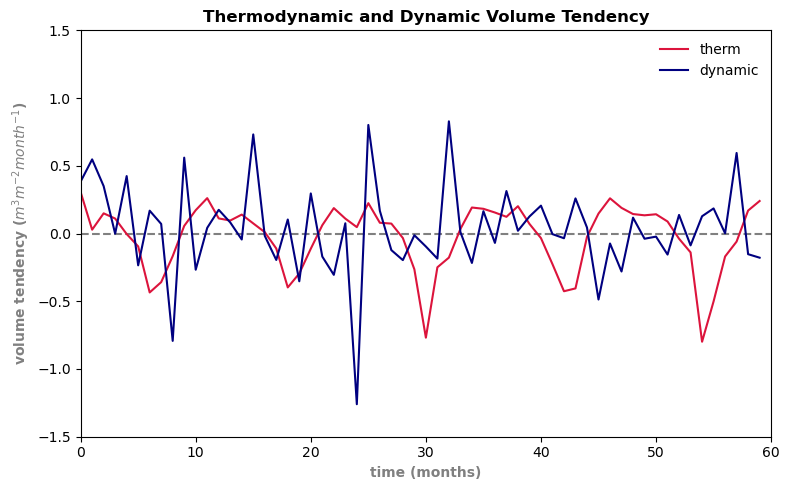

In [10]:
plt.figure(figsize=(8, 5))
plt.hlines(y=0, xmin=0, xmax=12 * 5, color="grey", linestyle="dashed")
plt.plot(therm.sidvol[-12 * 5 :, 375, 95], c="crimson", label="therm")
plt.plot(dynam.sidvol[-12 * 5 :, 375, 95], c="navy", label="dynamic")
plt.title("Thermodynamic and Dynamic Volume Tendency", fontweight="bold")
plt.xlabel("time (months)", fontweight="bold", color="grey")
plt.ylabel(
    "volume tendency ($m^3 m^{-2} month ^{-1}$)", fontweight="bold", color="grey"
)
plt.ylim([-1.5, 1.5])
plt.xlim([0, 12 * 5])
plt.legend(frameon=False)
plt.tight_layout()

Now reconstruct timeseries from piControl sithick and siconc (for grid cell volume, $m^3 m^{-2}$)

In [8]:
paththick = sorted(
    glob.glob(
        "/glade/collections/cmip/CMIP6/CMIP/NCAR/CESM2/piControl/r1i1p1f1/SImon/sithick/gn/v20190320/*"
    )
)
pathconc = sorted(
    glob.glob(
        "/glade/collections/cmip/CMIP6/CMIP/NCAR/CESM2/piControl/r1i1p1f1/SImon/siconc/gn/v20190320/*"
    )
)

In [9]:
thick = xr.open_mfdataset(paththick, parallel=True)
conc = xr.open_mfdataset(pathconc, parallel=True)

/glade/u/home/mollyw/.local/lib/python3.7/site-packages/xarray/conventions.py:520: SerializationWarning: variable 'sithick' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  decode_timedelta=decode_timedelta,
/glade/u/home/mollyw/.local/lib/python3.7/site-packages/xarray/conventions.py:520: SerializationWarning: variable 'siconc' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  decode_timedelta=decode_timedelta,


In [10]:
hi = thick.sithick * conc.siconc / 100
start = hi[-12 * 100 - 1]

In [11]:
thtend = therm.sidvol[-12 * 100 :].cumsum(dim="time")
dytend = dynam.sidvol[-12 * 100 :].cumsum(dim="time")

In [12]:
thermodynamic = thtend + start
dynamic = dytend + start
reconstructed = thtend + dytend + start
actual = hi[-12 * 100 :]

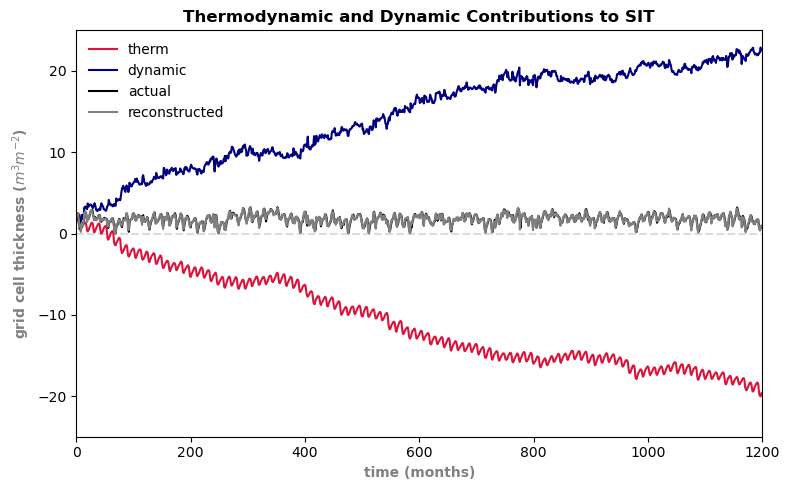

In [16]:
plt.figure(figsize=(8, 5))
plt.hlines(y=0, xmin=0, xmax=12 * 100, color="gainsboro", linestyle="dashed")
plt.plot(thermodynamic[:, 375, 95], c="crimson", label="therm")
plt.plot(dynamic[:, 375, 95], c="navy", label="dynamic")
plt.plot(actual[:, 375, 95], c="black", label="actual")
plt.plot(reconstructed[:, 375, 95], c="grey", label="reconstructed")
plt.title("Thermodynamic and Dynamic Contributions to SIT", fontweight="bold")
plt.xlabel("time (months)", fontweight="bold", color="grey")
plt.ylabel("grid cell thickness ($m^3 m^{-2}$)", fontweight="bold", color="grey")
plt.ylim([-25, 25])
plt.xlim([0, 12 * 100])
plt.legend(frameon=False)
plt.tight_layout()

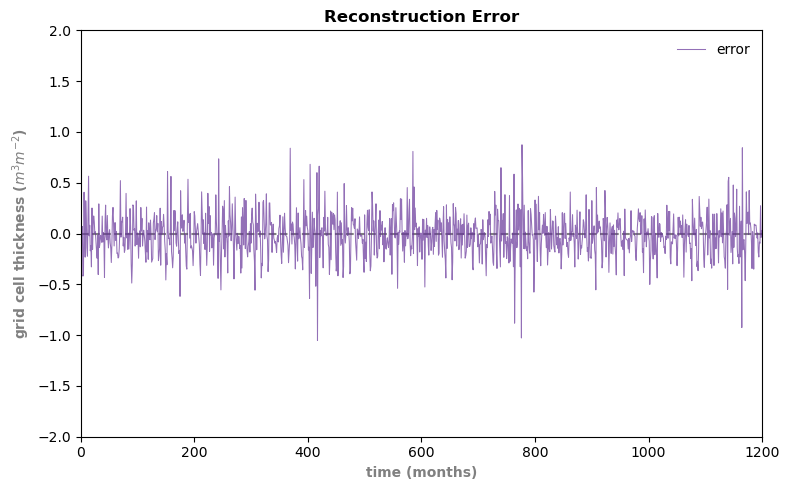

In [17]:
plt.figure(figsize=(8, 5))
plt.hlines(y=0, xmin=0, xmax=12 * 100, color="grey", linestyle="dashed")
plt.plot(
    reconstructed[:, 375, 95] - actual[-12 * 100 :, 375, 95],
    color="rebeccapurple",
    alpha=0.7,
    linewidth=0.75,
    label="error",
)
plt.xlim([0, 12 * 100])
plt.ylim([-2, 2])
plt.title("Reconstruction Error", fontweight="bold")
plt.xlabel("time (months)", fontweight="bold", color="grey")
plt.ylabel("grid cell thickness ($m^3 m^{-2}$)", fontweight="bold", color="grey")
plt.legend(frameon=False)
plt.tight_layout()

## Autocorrelation Maps

In [14]:
dtnd_thermo = get_monthly_anomalies(thermodynamic)
dtnd_dynamic = get_monthly_anomalies(dynamic)

In [23]:
data_list = [dtnd_thermo, dtnd_dynamic]
case = [
    "Thermodynamic",
    "Dynamic",
    "D - TD",
    "Dynamic Lead Thermo",
    "Thermo Lead Dynamic",
    "TLD - DLT",
]

/glade/u/home/mollyw/.conda/envs/preprocess/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/home/mollyw/.conda/envs/preprocess/lib/python3.8/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


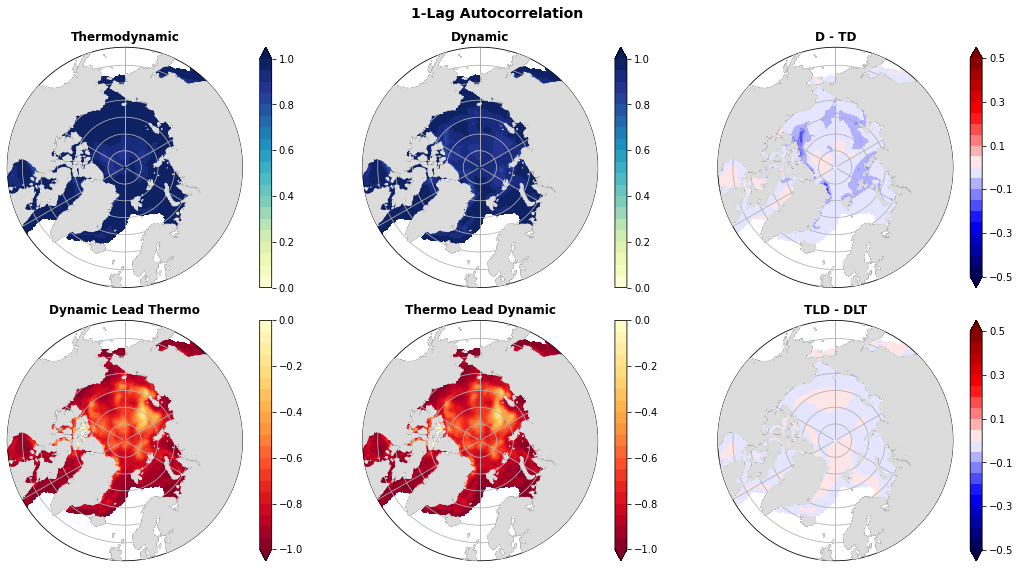

In [22]:
count = 0
count1 = 0
count2 = 0

AUTO = []

fig, axes = plt.subplots(
    nrows=2,
    ncols=3,
    figsize=(15, 8),
    subplot_kw={"projection": ccrs.NorthPolarStereo()},
)
for i in range(0, 4):
    if i < 2:
        anomalies1 = data_list[i]
        anomalies2 = anomalies1
    elif i == 2:
        anomalies1 = data_list[0]
        anomalies2 = data_list[1]
    else:
        anomalies1 = data_list[1]
        anomalies2 = data_list[0]

    auto, cov, damp = markov_2(anomalies1, anomalies2, 1)
    AUTO.append(auto)

AUTO.append(AUTO[1] - AUTO[0])
AUTO.append(AUTO[3] - AUTO[2])

for i in range(0, len(AUTO)):

    if i in [0, 1, 5]:
        data = AUTO[i]
        if i in [0, 1]:
            upper = 1
            clevs_label = np.linspace(0, upper, 6)
            clevs = np.linspace(0, upper, 21)
            extend = "max"
            cmap = plt.cm.YlGnBu
        else:
            upper = 0.5
            clevs_label = np.linspace(-1 * upper, upper, 6)
            clevs = np.linspace(-1 * upper, upper, 21)
            extend = "both"
            cmap = plt.cm.seismic

    elif i == 2:
        data = AUTO[4]
        upper = 0.5
        clevs_label = np.linspace(-1 * upper, upper, 6)
        clevs = np.linspace(-1 * upper, upper, 21)
        extend = "both"
        cmap = plt.cm.seismic

    elif i in [3, 4]:
        data = AUTO[i - 1]
        upper = 0
        clevs_label = np.linspace(-1, upper, 6)
        clevs = np.linspace(-1, upper, 21)
        extend = "min"
        cmap = plt.cm.YlOrRd_r
    else:
        print("something is missing!")

    ax = axes[count1][count2]
    fashion_space(ax)

    xs, ys, data_to_plot = convert_coords(
        data.lat, data.lon, data, ccrs.NorthPolarStereo()
    )
    img = ax.contourf(
        xs,
        ys,
        data_to_plot,
        clevs,
        transform=ccrs.NorthPolarStereo(),
        cmap=cmap,
        extend=extend,
    )
    cbar2 = fig.colorbar(img, ax=ax, ticks=clevs_label)
    ax.set_title(case[i], fontweight="bold", fontsize=12)

    count += 1
    count2 += 1
    if count2 > 2:
        count2 = 0
        count1 += 1

plt.suptitle("1-Lag Autocorrelation", fontweight="bold", fontsize=14)
plt.tight_layout()

## Filtering

In [13]:
inter = 12
nyquist = 1/2
nints = inter*10
cutoff = 1/nints*1/nyquist
decadal_sos = signal.butter(4, cutoff, 'lp', output='sos')
ann2dec_sos = signal.butter(4, [1/(inter*10) * 2, 1/(inter*1.5) * 2], 'bp', output='sos')
annual_sos = signal.butter(4, [1/(inter*1.5) * 2, 1/(inter*0.5) * 2], 'bp', output='sos')
s2s_sos = signal.butter(4, 1/(inter*0.5) * 2, 'hp', output='sos')

In [19]:
thermo_anomalies = dtnd_thermo.load()

/glade/u/home/mollyw/.conda/envs/markov_model/lib/python3.7/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


In [26]:
therm_decadal_filtered = xr.apply_ufunc(partial(signal.sosfilt, decadal_sos),
                                  thermo_anomalies,
                                  # dask='parallelized',
                                  output_dtypes=[thermo_anomalies.dtype],
                                  kwargs={'axis': 0})

In [27]:
therm_ann2dec_filtered = xr.apply_ufunc(partial(signal.sosfilt, ann2dec_sos),
                                  thermo_anomalies,
                                  # dask='parallelized',
                                  output_dtypes=[thermo_anomalies.dtype],
                                  kwargs={'axis': 0})

In [28]:
therm_annual_filtered = xr.apply_ufunc(partial(signal.sosfilt, annual_sos),
                                 thermo_anomalies,
                                 # dask='parallelized',
                                 output_dtypes=[thermo_anomalies.dtype],
                                 kwargs={'axis': 0})

In [29]:
therm_s2s_filtered = xr.apply_ufunc(partial(signal.sosfilt, s2s_sos),
                              thermo_anomalies,
                              # dask='parallelized',
                              output_dtypes=[thermo_anomalies.dtype],
                              kwargs={'axis': 0})

In [24]:
dyn_anomalies = dtnd_dynamic.load()

/glade/u/home/mollyw/.conda/envs/markov_model/lib/python3.7/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


In [30]:
dyn_decadal_filtered = xr.apply_ufunc(partial(signal.sosfilt, decadal_sos),
                                  dyn_anomalies,
                                  # dask='parallelized',
                                  output_dtypes=[dyn_anomalies.dtype],
                                  kwargs={'axis': 0})
dyn_ann2dec_filtered = xr.apply_ufunc(partial(signal.sosfilt, ann2dec_sos),
                                  dyn_anomalies,
                                  # dask='parallelized',
                                  output_dtypes=[dyn_anomalies.dtype],
                                  kwargs={'axis': 0})
dyn_annual_filtered = xr.apply_ufunc(partial(signal.sosfilt, annual_sos),
                                 dyn_anomalies,
                                 # dask='parallelized',
                                 output_dtypes=[dyn_anomalies.dtype],
                                 kwargs={'axis': 0})
dyn_s2s_filtered = xr.apply_ufunc(partial(signal.sosfilt, s2s_sos),
                              dyn_anomalies,
                              # dask='parallelized',
                              output_dtypes=[dyn_anomalies.dtype],
                              kwargs={'axis': 0})

In [41]:
data_list = {"tdec": therm_decadal_filtered.std(dim='time'), "ddec": dyn_decadal_filtered.std(dim='time'),
             "decdiff": therm_decadal_filtered.std(dim='time') - dyn_decadal_filtered.std(dim='time'),
             "ta2d": therm_ann2dec_filtered.std(dim='time'), "da2d": dyn_ann2dec_filtered.std(dim='time'),
             "a2ddiff": therm_ann2dec_filtered.std(dim='time') - dyn_ann2dec_filtered.std(dim='time'),
             "tann": therm_annual_filtered.std(dim='time'), "dann": dyn_annual_filtered.std(dim='time'),
             "anndiff": therm_annual_filtered.std(dim='time') - dyn_annual_filtered.std(dim='time'),
             "ts2s": therm_s2s_filtered.std(dim='time'), "ds2s": dyn_s2s_filtered.std(dim='time'),
             "s2sdiff": therm_s2s_filtered.std(dim='time') - dyn_s2s_filtered.std(dim='time'),
           }

In [50]:
mean_data_list = {"tdec": therm_decadal_filtered.mean(dim='time'), "ddec": dyn_decadal_filtered.mean(dim='time'),
             "decdiff": therm_decadal_filtered.mean(dim='time') - dyn_decadal_filtered.mean(dim='time'),
             "ta2d": therm_ann2dec_filtered.mean(dim='time'), "da2d": dyn_ann2dec_filtered.mean(dim='time'),
             "a2ddiff": therm_ann2dec_filtered.mean(dim='time') - dyn_ann2dec_filtered.mean(dim='time'),
             "tann": therm_annual_filtered.mean(dim='time'), "dann": dyn_annual_filtered.mean(dim='time'),
             "anndiff": therm_annual_filtered.mean(dim='time') - dyn_annual_filtered.mean(dim='time'),
             "ts2s": therm_s2s_filtered.mean(dim='time'), "ds2s": dyn_s2s_filtered.mean(dim='time'),
             "s2sdiff": therm_s2s_filtered.mean(dim='time') - dyn_s2s_filtered.mean(dim='time'),
           }

In [51]:
names= ["tdec","ddec", "decdiff", "ta2d","da2d", "a2ddiff", "tann","dann", "anndiff", "ts2s","ds2s", "s2sdiff"]

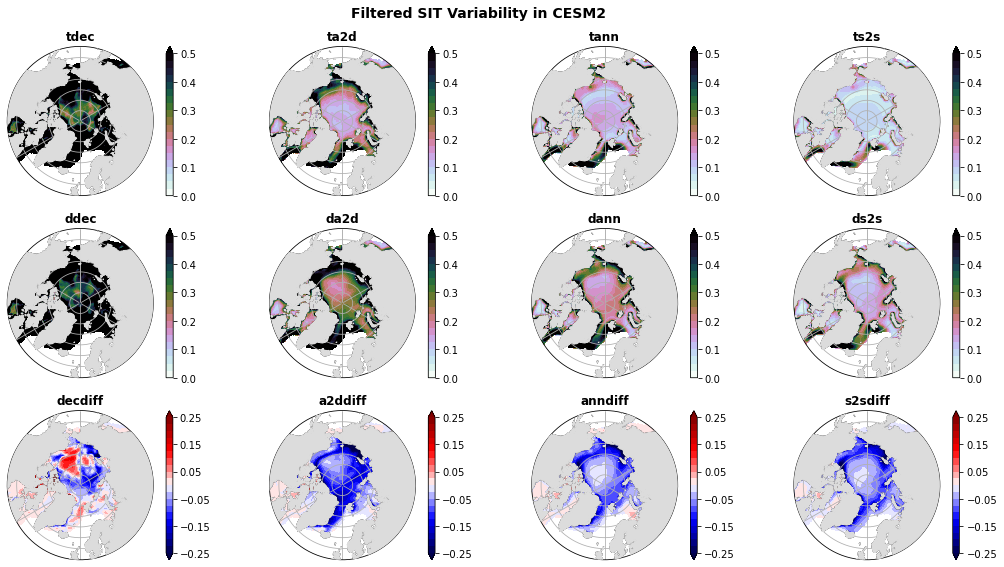

In [47]:
count = 0
count1 = 0
count2 = 0

fig, axes = plt.subplots(nrows=3, ncols=4,
                         figsize=(15, 8),
                         subplot_kw={'projection': ccrs.NorthPolarStereo()})
for name in names: 
    
    ax = axes[count1][count2]
    fashion_space(ax)

    xs, ys, data_to_plot = convert_coords(data_list[name].lat, data_list[name].lon, data_list[name], ccrs.NorthPolarStereo())
    if count in [2,5,8,11]:
        cmap = plt.cm.seismic
        clevs_label = np.linspace(-0.25, 0.25, 6)
        clevs = np.linspace(-0.25, 0.25, 21)
        img = ax.contourf(xs, ys, data_to_plot, clevs, transform=ccrs.NorthPolarStereo(), cmap=cmap, extend = 'both')
    else:
        cmap = plt.cm.cubehelix_r
        clevs_label = np.linspace(0, 0.5, 6)
        clevs = np.linspace(0, 0.5, 21)
        img = ax.contourf(xs, ys, data_to_plot, clevs, transform=ccrs.NorthPolarStereo(), cmap=cmap, extend = 'max')
    cbar2 = fig.colorbar(img, ax=ax, ticks= clevs_label)
    ax.set_title(name, fontweight='bold', fontsize=12)

    count += 1
    count1 += 1
    if count1 > 2:
        count1 = 0
        count2 += 1

plt.suptitle('Filtered SIT Variability in CESM2', fontweight='bold', fontsize=14)
plt.tight_layout()

## Different Lead Times

I am not super well versed in dask, but these tasks seem to need A LOT of memory. Could probably parallelize using xr.apply_ufunc but that is too complicated for me on a Friday

In [59]:
def explore_lags(anom1, anom2, lag=-12, lead=12):
    autos = []
    for i in range(lag, lead + 2, 2):
        auto, cov, damp = markov_2(anom1, anom2, i)
        autos.append(auto)

    return autos


Add = explore_lags(anom1=dtnd_dynamic, anom2=dtnd_dynamic)

Att = explore_lags(anom1=dtnd_thermo, anom2=dtnd_thermo)

Acc = explore_lags(anom1=dtnd_thermo, anom2=dtnd_dynamic)

In [60]:
import pickle

def to_pickle(path, obj): 
     with open(path, 'wb') as handle:
            pickle.dump(obj, handle, protocol=pickle.HIGHEST_PROTOCOL)
            
lonC, latC = 375, 95
Add_p = [a[lonC, latC].values for a in Add]
to_pickle("Add.pkl", Add_p)
print("Done with Add")

Att_p = [a[lonC, latC].values for a in Att]
to_pickle("Att.pkl", Att_p)
print("Done with Att")

Acc_p = [a[lonC, latC].values for a in Acc]
to_pickle("Acc.pkl", Acc_p)
print("Done with Acc")
            

Done with Add
Done with Att
Done with Acc


As a sanity check, plot the correlation times at a random location

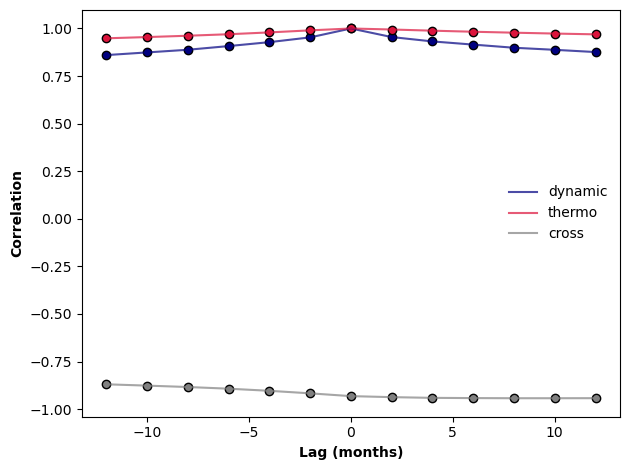

In [61]:
lagtimes = range(-12, 14, 2)

plt.plot(lagtimes, Add_p, c="navy", label="dynamic", alpha=0.7)
plt.plot(lagtimes, Att_p, c="crimson", label="thermo", alpha=0.7)
plt.plot(lagtimes, Acc_p, c="gray", label="cross", alpha=0.7)

plt.scatter(lagtimes, Add_p, c="navy", edgecolor="black")
plt.scatter(lagtimes, Att_p, c="crimson", edgecolor="black")
plt.scatter(lagtimes, Acc_p, c="gray", edgecolor="black")

plt.ylabel("Correlation", fontweight="bold")
plt.xlabel("Lag (months)", fontweight="bold")
plt.legend(frameon=False)
plt.tight_layout()
plt.savefig("correlation_lagtimes.png")